<a href="https://colab.research.google.com/github/Kimhantag/Posco_AIBigdata_Academy25_edu/blob/main/7.GAN_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모델 동작에 필요한 사전 준비

In [ ]:
! pip install tensorflow_datasets

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import Model, layers

In [ ]:
# gpu를 사용하게 하는 코드
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## 데이터 불러오기 및 전처리

In [ ]:
# 이번 GAN 실습에 활용될 MNIST 데이터를 다운로드한 후,
# 불러온 데이터를 Training용과 Testing용으로 나누는 과정
# 모든 이미지 데이터의 크기는 28 x 28 x 1 (흑백)

dataset = tfds.load('mnist', split = 'train')
batch_size = 1024
train_data = dataset.map(lambda data: tf.cast(data['image'], tf.float32) / 255.).batch(batch_size)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## GAN 구현

### GAN의 생성자 (Generator) 구현

In [ ]:
# GAN의 생성자 (Generator)

class Generator(Model):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim # 50
        self.generator = tf.keras.Sequential([
            layers.Dense(7*7*32, activation = 'relu'), # 7*7*32
            layers.Reshape([7,7,32]),
            layers.Conv2DTranspose(64,3, strides = 2, padding = 'same', activation = 'relu'),
            layers.Conv2DTranspose(32,3, strides = 2, padding = 'same', activation = 'relu'),
            layers.Conv2DTranspose(1,3, strides = 1, padding = 'same', activation = 'sigmoid') # 28, 28, 1
        ])
    def call(self,z):
      return self.generator(z)


### GAN의 판별자 (Discriminator) 구현

In [ ]:
# GAN의 판별자 (Discriminator)

class Discriminator(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.discriminator = tf.keras.Sequential([
            layers.Conv2D(32,3,strides = 2, activation = 'relu', padding='same', input_shape = (28,28,1)),
            layers.Conv2D(64,3,strides = 2, activation = 'relu', padding='same'),
            layers.Flatten(),
            layers.Dense(1)
            ])

    def call(self, x):
      return self.discriminator(x)

### GAN 구조 정의

In [ ]:
# Hyperparameters
n_epochs = 40
latent_dim = 10
log_interval = 4

In [ ]:
# GAN의 생성자와 판별자
generator = Generator(latent_dim)
discriminator = Discriminator(latent_dim)

# Optimizer 정의
optimizer_g = tf.keras.optimizers.Adam(1e-3)
optimizer_d = tf.keras.optimizers.Adam(1e-3)

## Training

### Loss Function 정의

In [ ]:
# Loss function은 binary cross entropy (BCE)로 정의

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def train_step(inputs):
  noises = tf.random.normal([batch_size, latent_dim]) #(1024, 10)
  with tf.GradientTape() as tape_g, tf.GradientTape() as tape_d:

    x = generator(noises) # fake images

    real_output = discriminator(inputs) # real images | [1024]
    fake_output = discriminator(x) # fake images | [1024]

    loss_g = loss(tf.ones_like(fake_output),fake_output) # 1, 0 -> 1
    loss_d = loss(tf.zeros_like(fake_output),fake_output) + loss(tf.ones_like(real_output),real_output)

  grads_g = tape_g.gradient(loss_g, generator.trainable_variables)
  grads_d = tape_d.gradient(loss_d, discriminator.trainable_variables)

  optimizer_g.apply_gradients(zip(grads_g, generator.trainable_variables))
  optimizer_d.apply_gradients(zip(grads_d, discriminator.trainable_variables))
  return loss_g, loss_d

In [ ]:
# 실제 Training 과정

for epoch in range(1, n_epochs + 1):
    total_loss_g, total_loss_d = 0, 0

    for x in train_data:
      loss_g, loss_d = train_step(x)
      total_loss_g += loss_g
      total_loss_d += loss_d

    if epoch % log_interval == 0:
        print(f'Epoch {epoch:3d} - Generator loss: {total_loss_g:.2f}, Discriminator loss: {total_loss_d:.2f}')

Epoch   4 - Generator loss: 252.24, Discriminator loss: 9.62
Epoch   8 - Generator loss: 245.73, Discriminator loss: 24.41
Epoch  12 - Generator loss: 147.51, Discriminator loss: 29.04
Epoch  16 - Generator loss: 164.32, Discriminator loss: 25.76
Epoch  20 - Generator loss: 113.42, Discriminator loss: 56.04
Epoch  24 - Generator loss: 147.34, Discriminator loss: 47.40
Epoch  28 - Generator loss: 116.60, Discriminator loss: 46.24
Epoch  32 - Generator loss: 112.34, Discriminator loss: 46.79
Epoch  36 - Generator loss: 106.91, Discriminator loss: 41.44
Epoch  40 - Generator loss: 109.83, Discriminator loss: 49.22


## Testing

### 생성자 동작 확인

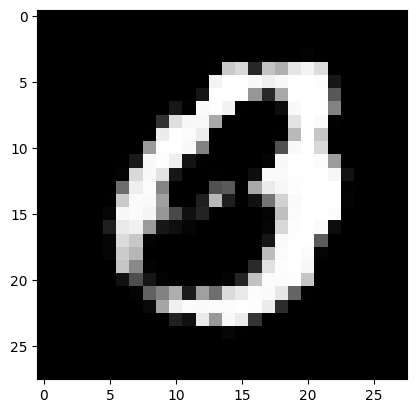

In [ ]:
# 학습된 GAN 모델의 생성자로 MNIST 이미지 Sampling 및 시각화

noise = tf.random.normal([1, latent_dim])
x= generator(noise)

plt.imshow(x[0, :, :, 0], cmap = 'gray')

### 학습된 GAN 모델로 MNIST 이미지 생성

In [ ]:
# 여러 개의 MNIST 이미지들을 Sampling하는 함수 정의
# n * n 정사각형 배치의 MNIST 이미지 생성 및 출력

def plot_latent_images(n, digit_size = 28):
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i in range(n):
        for j in range(n):
            noise = tf.random.normal([1, latent_dim])
            x = generator(noise)
            image[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = x[0, :, :, 0]

    plt.figure(figsize = (10, 10))
    plt.imshow(image, cmap = 'Greys_r')
    plt.axis('Off')
    plt.show()

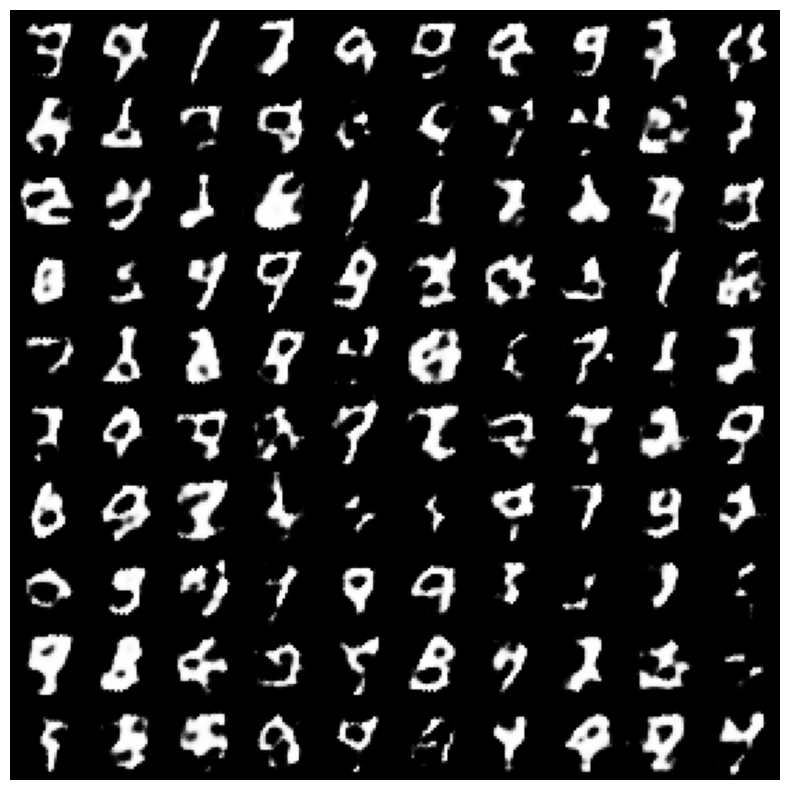

In [ ]:
# MNIST 이미지 생성
# 여기서는 10 * 10 = 100개의 MNIST 이미지 생성

plot_latent_images(10)